In [1]:
# 05_contrastive_learning.ipynb
'''Task:Contrastive representation learning for tabular multimodal features (SimCLR-style).  
- Pretrain an encoder with a contrastive objective (SimCLR NT-Xent).
- Evaluate learned representations with a linear probe (logistic regression).
- If PyTorch is not available, run a strong fallback that approximates the contrastive idea with pairwise classification + PCA embeddings.
- Save encoders, probes, scalers and results to `models/` and `reports/`.
'''

'Task:Contrastive representation learning for tabular multimodal features (SimCLR-style).  \n- Pretrain an encoder with a contrastive objective (SimCLR NT-Xent).\n- Evaluate learned representations with a linear probe (logistic regression).\n- If PyTorch is not available, run a strong fallback that approximates the contrastive idea with pairwise classification + PCA embeddings.\n- Save encoders, probes, scalers and results to `models/` and `reports/`.\n'

In [2]:
# Standard imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import time
import json
import math
from pprint import pprint

# Data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Save/IO
import joblib

# PyTorch availability
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Repro
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TORCH_AVAILABLE:
    torch.manual_seed(RANDOM_SEED)

# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
PLOTS_DIR = ROOT / "plots"
for d in (MODELS_DIR, REPORTS_DIR, PLOTS_DIR):
    d.mkdir(parents=True, exist_ok=True)

timestamp = time.strftime("%Y%m%d_%H%M%S")
print("PyTorch available:", TORCH_AVAILABLE)


PyTorch available: True


In [3]:
def save_joblib(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(obj, path)
    print("Saved joblib:", path)

def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print("Saved json:", path)


In [4]:
# Load data produced by preprocessing
X_train = pd.read_csv(DATA_DIR / "X_train.csv")
X_test  = pd.read_csv(DATA_DIR / "X_test.csv")
y_train = pd.read_csv(DATA_DIR / "y_train.csv").squeeze()
y_test  = pd.read_csv(DATA_DIR / "y_test.csv").squeeze()

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

# Label encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
save_joblib(le, MODELS_DIR / f"label_encoder_{timestamp}.joblib")

# Scale features (use same scaler for all experiments)
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
save_joblib(scaler, MODELS_DIR / f"scaler_{timestamp}.joblib")


Shapes -> X_train: (1158, 54) X_test: (290, 54)
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\label_encoder_20251017_233616.joblib
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\scaler_20251017_233616.joblib


In [5]:
# Train logistic regression directly on raw scaled features (baseline)
baseline = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
baseline.fit(X_train_s, y_train_enc)
preds_base = baseline.predict(X_test_s)
base_acc = accuracy_score(y_test_enc, preds_base)
base_f1  = f1_score(y_test_enc, preds_base, average="macro")
print("Baseline LogisticRegression -> acc: {:.4f}, f1_macro: {:.4f}".format(base_acc, base_f1))

save_joblib(baseline, MODELS_DIR / f"baseline_logreg_{timestamp}.joblib")


Baseline LogisticRegression -> acc: 0.7759, f1_macro: 0.5977
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_logreg_20251017_233616.joblib


In [6]:
# Augmentations used by SimCLR-style pipeline for tabular data.
# They are intentionally simple and conservative: gaussian noise, feature dropout, minor scaling.
def augment_tabular(x_batch, noise_std=0.05, drop_prob=0.1, scale_std=0.02, rng=None):
    """
    x_batch: numpy array (n, d)
    returns augmented batch of same shape
    """
    rng = rng or np.random.RandomState()
    x = x_batch.copy()
    # additive gaussian noise
    if noise_std > 0:
        x = x + rng.normal(loc=0.0, scale=noise_std, size=x.shape)
    # feature dropout
    if drop_prob > 0:
        mask = rng.rand(*x.shape) < drop_prob
        x[mask] = 0.0
    # multiplicative small scaling
    if scale_std > 0:
        scales = 1.0 + rng.normal(0.0, scale_std, size=(x.shape[0], 1))
        x = x * scales
    return x


In [7]:
# Contrastive training hyperparameters (tune as needed)
CFG = {
    "batch_size": 256,
    "epochs": 120,
    "lr": 1e-3,
    "temperature": 0.5,
    "proj_hidden": 256,
    "proj_out_dim": 128,
    "encoder_hidden": 512,
    "dropout": 0.2,
    "device": "cuda" if (TORCH_AVAILABLE and torch.cuda.is_available()) else "cpu"
}
pprint(CFG)


{'batch_size': 256,
 'device': 'cpu',
 'dropout': 0.2,
 'encoder_hidden': 512,
 'epochs': 120,
 'lr': 0.001,
 'proj_hidden': 256,
 'proj_out_dim': 128,
 'temperature': 0.5}


Using device: cpu
Effective batch size: 256
Epoch 1/120 — loss: 6.6151
Epoch 10/120 — loss: 5.4842
Epoch 20/120 — loss: 5.3898
Epoch 30/120 — loss: 5.3472
Epoch 40/120 — loss: 5.3292
Epoch 50/120 — loss: 5.3056
Epoch 60/120 — loss: 5.2945
Epoch 70/120 — loss: 5.2873
Epoch 80/120 — loss: 5.2549
Epoch 90/120 — loss: 5.2595
Epoch 100/120 — loss: 5.2493
Epoch 110/120 — loss: 5.2277
Epoch 120/120 — loss: 5.2180
Saved encoder: C:\Users\alfiy\ByteBuzz\Notebooks\models\simclr_encoder_20251017_233616.pt
Saved projection head: C:\Users\alfiy\ByteBuzz\Notebooks\models\simclr_proj_20251017_233616.pt
Saved json: C:\Users\alfiy\ByteBuzz\Notebooks\reports\simclr_history_20251017_233616.json
Linear probe -> acc: 0.7621, f1_macro: 0.5927
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\simclr_linprobe_20251017_233616.joblib


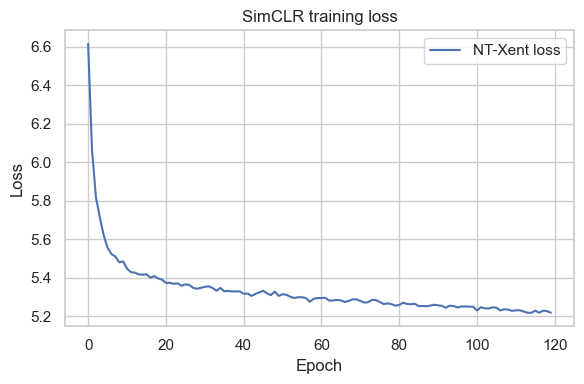

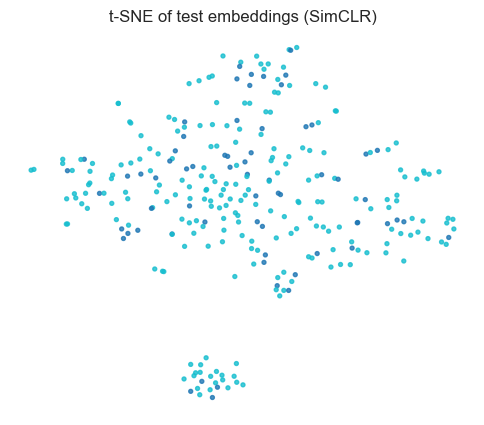

Saved json: C:\Users\alfiy\ByteBuzz\Notebooks\reports\simclr_results_20251017_233616.json


In [8]:
if TORCH_AVAILABLE:
    device = torch.device(CFG["device"])
    print("Using device:", device)

    # Simple MLP encoder + projection head
    class MLPEncoder(nn.Module):
        def __init__(self, input_dim, hidden_dim=512, dropout=0.2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        def forward(self, x):
            return self.net(x)

    class ProjectionHead(nn.Module):
        def __init__(self, in_dim, hidden=256, out_dim=128):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, out_dim)
            )
        def forward(self, x):
            return self.net(x)

    # NT-Xent loss
    def nt_xent_loss(z_i, z_j, temperature=0.5):
        """
        z_i, z_j: tensors (batch_size, dim), assumed already normalized or will be normalized
        returns scalar loss
        """
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)  # 2N x D
        z = nn.functional.normalize(z, dim=1)
        sim = torch.matmul(z, z.T)  # 2N x 2N similarity matrix
        # create positive mask
        labels = torch.arange(batch_size, device=z.device)
        labels = torch.cat([labels, labels], dim=0)
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()  # 2N x 2N
        # remove diagonal
        diag_mask = torch.eye(2*batch_size, device=z.device)
        mask = mask - diag_mask
        # compute logits
        logits = sim / temperature
        # for each i, denominator is sum over all except i
        exp_logits = torch.exp(logits) * (1 - diag_mask)
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # positive pairs: for index i, positive is j = i+-batch_size
        positive_idx = torch.arange(batch_size, device=z.device)
        pos_pairs = torch.cat([positive_idx + batch_size, positive_idx], dim=0)
        positives = log_prob[torch.arange(2*batch_size, device=z.device), pos_pairs]
        loss = -positives.mean()
        return loss

    # Create DataLoader for augmentations (we implement on-the-fly augmentations)
    X_tr_np = X_train_s.values.astype(np.float32)
    n_train = X_tr_np.shape[0]
    batch_size = min(CFG["batch_size"], n_train//2 if n_train//2>0 else n_train)
    print("Effective batch size:", batch_size)

    # Build models
    input_dim = X_tr_np.shape[1]
    encoder = MLPEncoder(input_dim, hidden_dim=CFG["encoder_hidden"], dropout=CFG["dropout"]).to(device)
    proj = ProjectionHead(in_dim=CFG["encoder_hidden"]//2, hidden=CFG["proj_hidden"], out_dim=CFG["proj_out_dim"]).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(proj.parameters()), lr=CFG["lr"], weight_decay=1e-6)

    # Training loop
    history = {"loss": []}
    rng = np.random.RandomState(RANDOM_SEED)
    n_batches = max(1, n_train // (2*batch_size))  # each batch uses 2*batch_size examples before augmentation pairing
    for epoch in range(1, CFG["epochs"]+1):
        perm = rng.permutation(n_train)
        epoch_loss = 0.0
        for b in range(n_batches):
            idx = perm[b*(2*batch_size): (b+1)*(2*batch_size)]
            if len(idx) < 2:
                continue
            Xb = X_tr_np[idx]
            # create two augmented views
            xa = augment_tabular(Xb, noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
            xb_aug = augment_tabular(Xb, noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
            xa_t = torch.tensor(xa, dtype=torch.float32).to(device)
            xb_t = torch.tensor(xb_aug, dtype=torch.float32).to(device)

            # forward
            h_a = encoder(xa_t)
            h_b = encoder(xb_t)
            z_a = proj(h_a)
            z_b = proj(h_b)

            loss = nt_xent_loss(z_a, z_b, temperature=CFG["temperature"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= max(1, n_batches)
        history["loss"].append(epoch_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{CFG['epochs']} — loss: {epoch_loss:.4f}")

    # Save encoder & proj (we save encoder state dict; the projection head is optional at inference)
    encoder_path = MODELS_DIR / f"simclr_encoder_{timestamp}.pt"
    proj_path = MODELS_DIR / f"simclr_proj_{timestamp}.pt"
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(proj.state_dict(), proj_path)
    print("Saved encoder:", encoder_path)
    print("Saved projection head:", proj_path)
    save_json(history, REPORTS_DIR / f"simclr_history_{timestamp}.json")

    # Build embeddings for train and test (use encoder; discard projection head)
    encoder.eval()
    with torch.no_grad():
        X_train_emb = encoder(torch.tensor(X_train_s.values.astype(np.float32)).to(device)).cpu().numpy()
        X_test_emb  = encoder(torch.tensor(X_test_s.values.astype(np.float32)).to(device)).cpu().numpy()

    # Linear evaluation: freeze encoder and train logistic regression on embeddings
    linprobe = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
    linprobe.fit(X_train_emb, y_train_enc)
    preds_lin = linprobe.predict(X_test_emb)
    lin_acc = accuracy_score(y_test_enc, preds_lin)
    lin_f1  = f1_score(y_test_enc, preds_lin, average="macro")
    print("Linear probe -> acc: {:.4f}, f1_macro: {:.4f}".format(lin_acc, lin_f1))

    save_joblib(linprobe, MODELS_DIR / f"simclr_linprobe_{timestamp}.joblib")

    # Plot loss curve
    plt.figure(figsize=(6,4))
    plt.plot(history["loss"], label="NT-Xent loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("SimCLR training loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"simclr_loss_{timestamp}.png", dpi=150)
    plt.show()

    # t-SNE of embeddings (visual)
    try:
        from sklearn.manifold import TSNE
        emb_sample_idx = np.random.choice(len(X_test_emb), size=min(1000, len(X_test_emb)), replace=False)
        emb2d = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_test_emb[emb_sample_idx])
        plt.figure(figsize=(6,5))
        plt.scatter(emb2d[:,0], emb2d[:,1], c=y_test_enc[emb_sample_idx], cmap="tab10", s=8, alpha=0.8)
        plt.title("t-SNE of test embeddings (SimCLR)")
        plt.axis("off")
        plt.savefig(PLOTS_DIR / f"simclr_tsne_{timestamp}.png", dpi=150)
        plt.show()
    except Exception as e:
        print("t-SNE skipped (error):", e)

    results = {
        "baseline_acc": float(base_acc),
        "baseline_f1": float(base_f1),
        "simclr_linprobe_acc": float(lin_acc),
        "simclr_linprobe_f1": float(lin_f1),
        "encoder_path": str(encoder_path),
        "proj_path": str(proj_path),
        "linprobe_path": str(MODELS_DIR / f"simclr_linprobe_{timestamp}.joblib")
    }
    save_json(results, REPORTS_DIR / f"simclr_results_{timestamp}.json")


In [9]:
#Fallback (no PyTorch) contrastive-approximation
if not TORCH_AVAILABLE:
    print("PyTorch not available — running fallback contrastive approximation.")

    rng = np.random.RandomState(RANDOM_SEED)

    # Generate positive pairs: two augmentations of same sample
    n_samples = X_train_s.shape[0]
    n_pos = min(20000, n_samples * 2)  # cap number of pairs
    pos_idx = rng.choice(n_samples, size=n_pos, replace=True)
    X_base = X_train_s.values
    X_a = augment_tabular(X_base[pos_idx], noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
    X_b = augment_tabular(X_base[pos_idx], noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
    y_pos = np.ones(len(pos_idx), dtype=int)

    # Generate negative pairs: two samples from different classes (hard negatives)
    class_to_idx = {}
    for cls in np.unique(y_train_enc):
        class_to_idx[cls] = np.where(y_train_enc == cls)[0]
    neg_pairs = []
    neg_count = len(pos_idx)
    for _ in range(neg_count):
        c1, c2 = rng.choice(np.unique(y_train_enc), size=2, replace=False)
        i1 = rng.choice(class_to_idx[c1])
        i2 = rng.choice(class_to_idx[c2])
        neg_pairs.append((i1, i2))
    X_neg_a = augment_tabular(X_base[[p[0] for p in neg_pairs]], noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
    X_neg_b = augment_tabular(X_base[[p[1] for p in neg_pairs]], noise_std=0.05, drop_prob=0.12, scale_std=0.02, rng=rng)
    y_neg = np.zeros(len(neg_pairs), dtype=int)

    # Create dataset of pairwise absolute differences and labels (1 = same, 0 = different)
    X_pairs = np.vstack([np.abs(X_a - X_b), np.abs(X_neg_a - X_neg_b)])
    y_pairs = np.concatenate([y_pos, y_neg])

    print("Pairs shape:", X_pairs.shape, "Labels shape:", y_pairs.shape)

    # Train a pairwise logistic regression to distinguish positive vs negative pairs
    pair_clf = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
    pair_clf.fit(X_pairs, y_pairs)
    save_joblib(pair_clf, MODELS_DIR / f"pairwise_clf_{timestamp}.joblib")
    print("Trained pairwise classifier (proxy for contrastive similarity).")

    # Now produce embeddings via PCA on the original features (PCA acts as learned low-dim projector)
    n_components = min(256, X_train_s.shape[1])
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_train_emb = pca.fit_transform(X_train_s.values)
    X_test_emb  = pca.transform(X_test_s.values)
    save_joblib(pca, MODELS_DIR / f"pca_emb_{timestamp}.joblib")

    # Linear probe on PCA embeddings
    linprobe = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
    linprobe.fit(X_train_emb, y_train_enc)
    preds_lin = linprobe.predict(X_test_emb)
    lin_acc = accuracy_score(y_test_enc, preds_lin)
    lin_f1  = f1_score(y_test_enc, preds_lin, average="macro")
    print("Fallback linear probe on PCA embeddings -> acc: {:.4f}, f1_macro: {:.4f}".format(lin_acc, lin_f1))
    save_joblib(linprobe, MODELS_DIR / f"fallback_linprobe_{timestamp}.joblib")

    results = {
        "baseline_acc": float(base_acc),
        "baseline_f1": float(base_f1),
        "pairwise_clf_path": str(MODELS_DIR / f"pairwise_clf_{timestamp}.joblib"),
        "pca_path": str(MODELS_DIR / f"pca_emb_{timestamp}.joblib"),
        "linprobe_acc": float(lin_acc),
        "linprobe_f1": float(lin_f1)
    }
    save_json(results, REPORTS_DIR / f"contrastive_fallback_results_{timestamp}.json")


In [10]:
# Load and show results that were saved in previous cells
if TORCH_AVAILABLE:
    res_path = REPORTS_DIR / f"simclr_results_{timestamp}.json"
    if res_path.exists():
        display(pd.read_json(res_path, typ="series"))
else:
    res_path = REPORTS_DIR / f"contrastive_fallback_results_{timestamp}.json"
    if res_path.exists():
        display(pd.read_json(res_path, typ="series"))

# Compare baseline vs representation linear probe
if TORCH_AVAILABLE:
    print("Baseline acc/f1:", base_acc, base_f1)
    print("SimCLR linear probe acc/f1:", lin_acc, lin_f1)
else:
    print("Baseline acc/f1:", base_acc, base_f1)
    print("Fallback linear probe acc/f1:", lin_acc, lin_f1)


baseline_acc                                                    0.775862
baseline_f1                                                     0.597661
simclr_linprobe_acc                                             0.762069
simclr_linprobe_f1                                              0.592721
encoder_path           C:\Users\alfiy\ByteBuzz\Notebooks\models\simcl...
proj_path              C:\Users\alfiy\ByteBuzz\Notebooks\models\simcl...
linprobe_path          C:\Users\alfiy\ByteBuzz\Notebooks\models\simcl...
dtype: object

Baseline acc/f1: 0.7758620689655172 0.5976606689291584
SimCLR linear probe acc/f1: 0.7620689655172413 0.5927214996641632
